<a href="https://colab.research.google.com/github/rhks13/Anomaly-Detection/blob/main/univar_ts_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('/content/drive/MyDrive/AI/이상 탐지/taxi_dataset.csv',index_col=0)

In [6]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


In [7]:
import plotly.express as px
fig = px.line(df, x="timestamp", y="value", title="taxi demand in NewYork")
fig.show()

In [57]:
df_ts = df.copy()
df_ts.set_index('timestamp', inplace=True)

In [58]:
df_ts.index = pd.to_datetime(df_ts.index)

In [68]:
ts = df_ts.resample('D').mean()
print(ts.index)
ts

DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2015-01-22', '2015-01-23', '2015-01-24', '2015-01-25',
               '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29',
               '2015-01-30', '2015-01-31'],
              dtype='datetime64[ns]', name='timestamp', length=215, freq='D')


,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model='additive') #가법모형

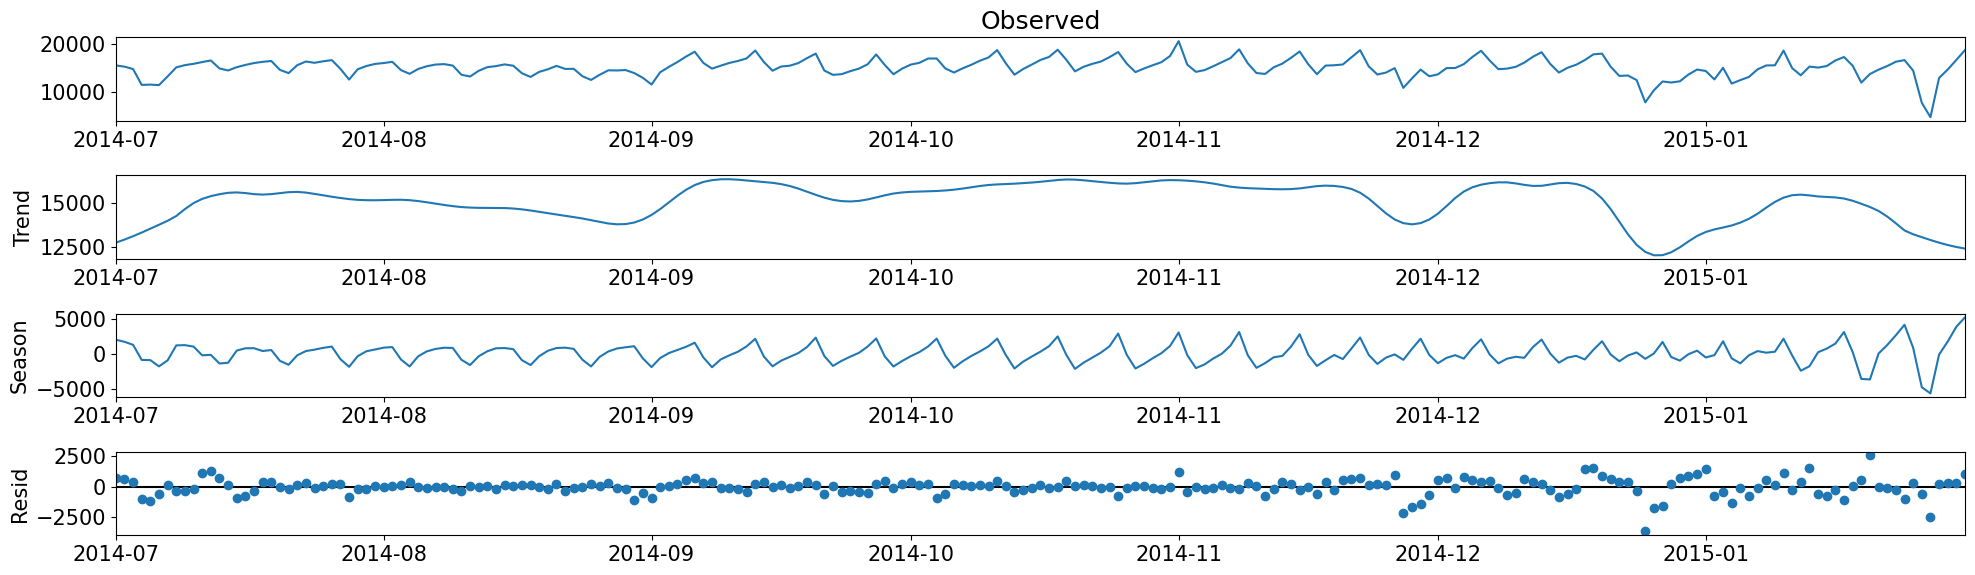

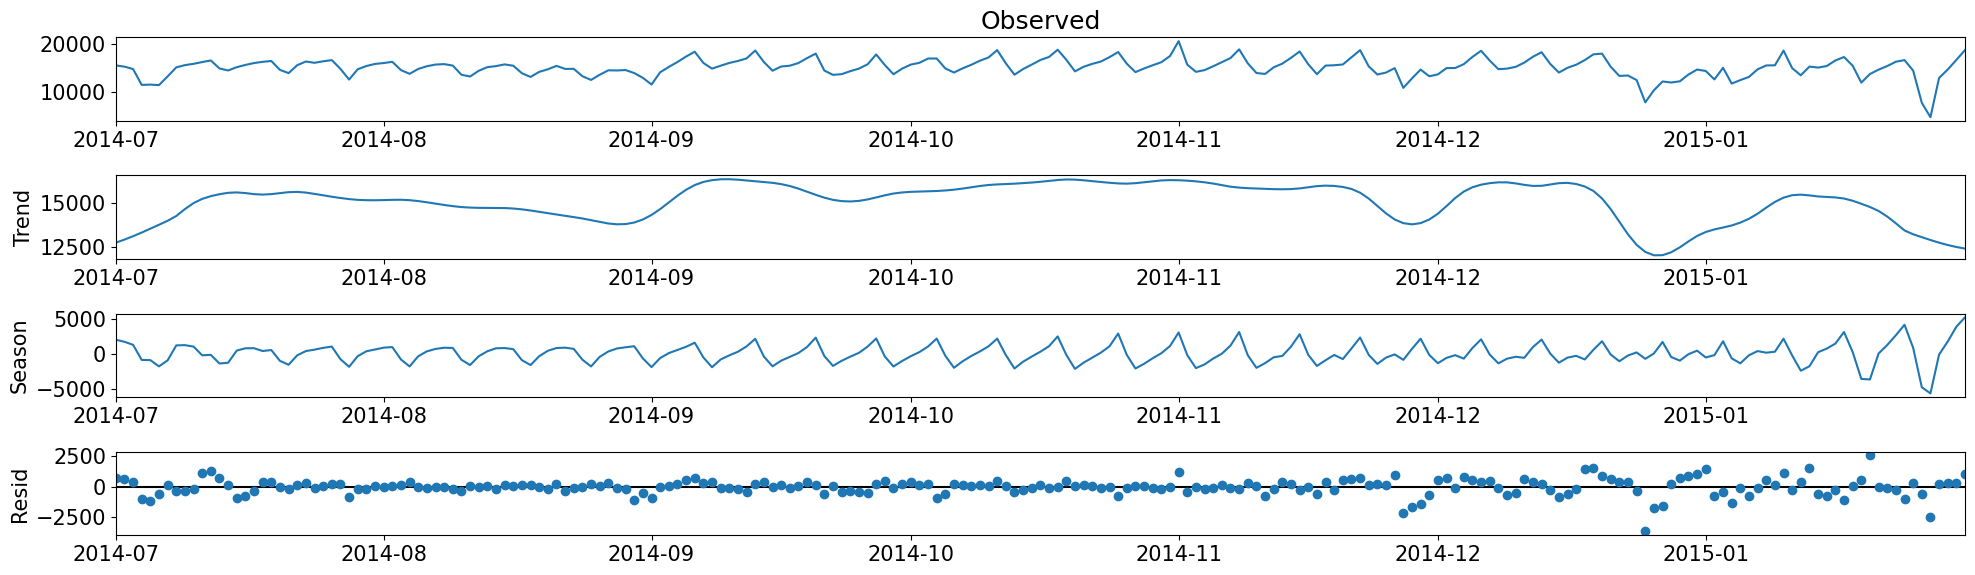

In [70]:
from statsmodels.tsa.seasonal import STL
res = STL(ts).fit()
res.plot()

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
# 곱하기(승법적) 분해
result_mul = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')

# 더하기(가법적) 분해
result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

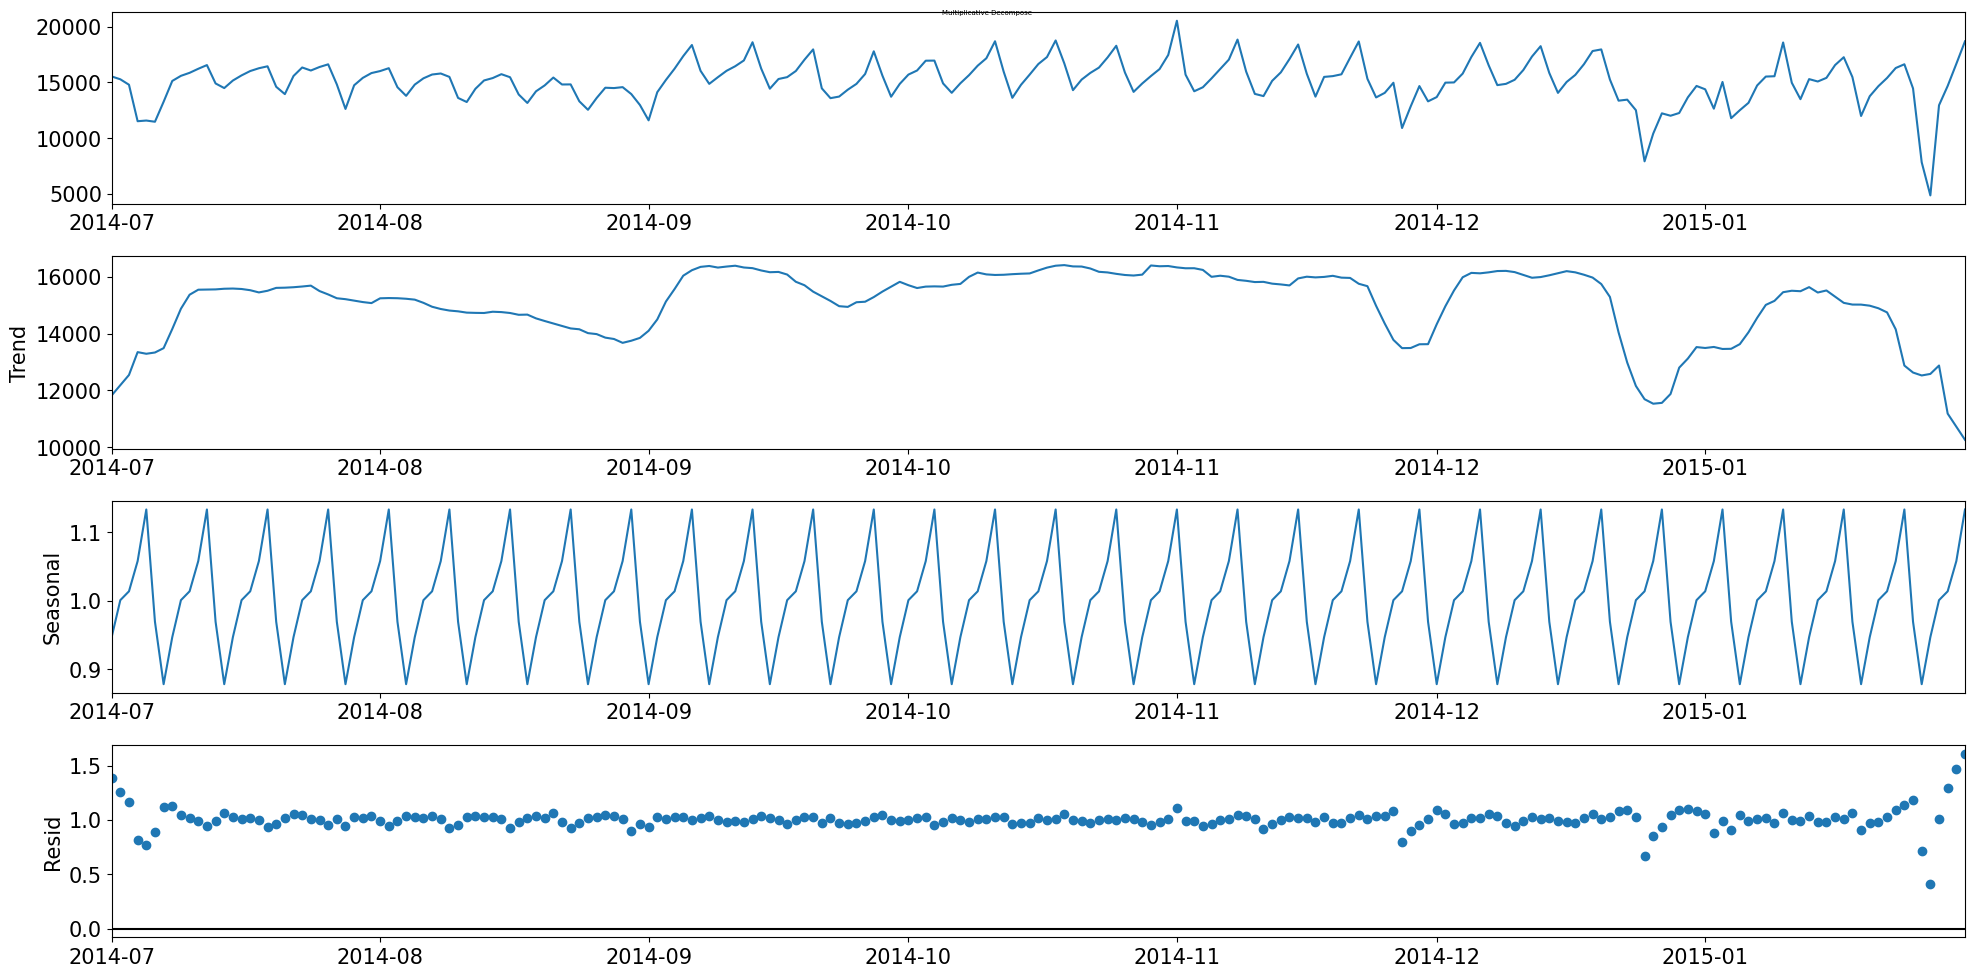

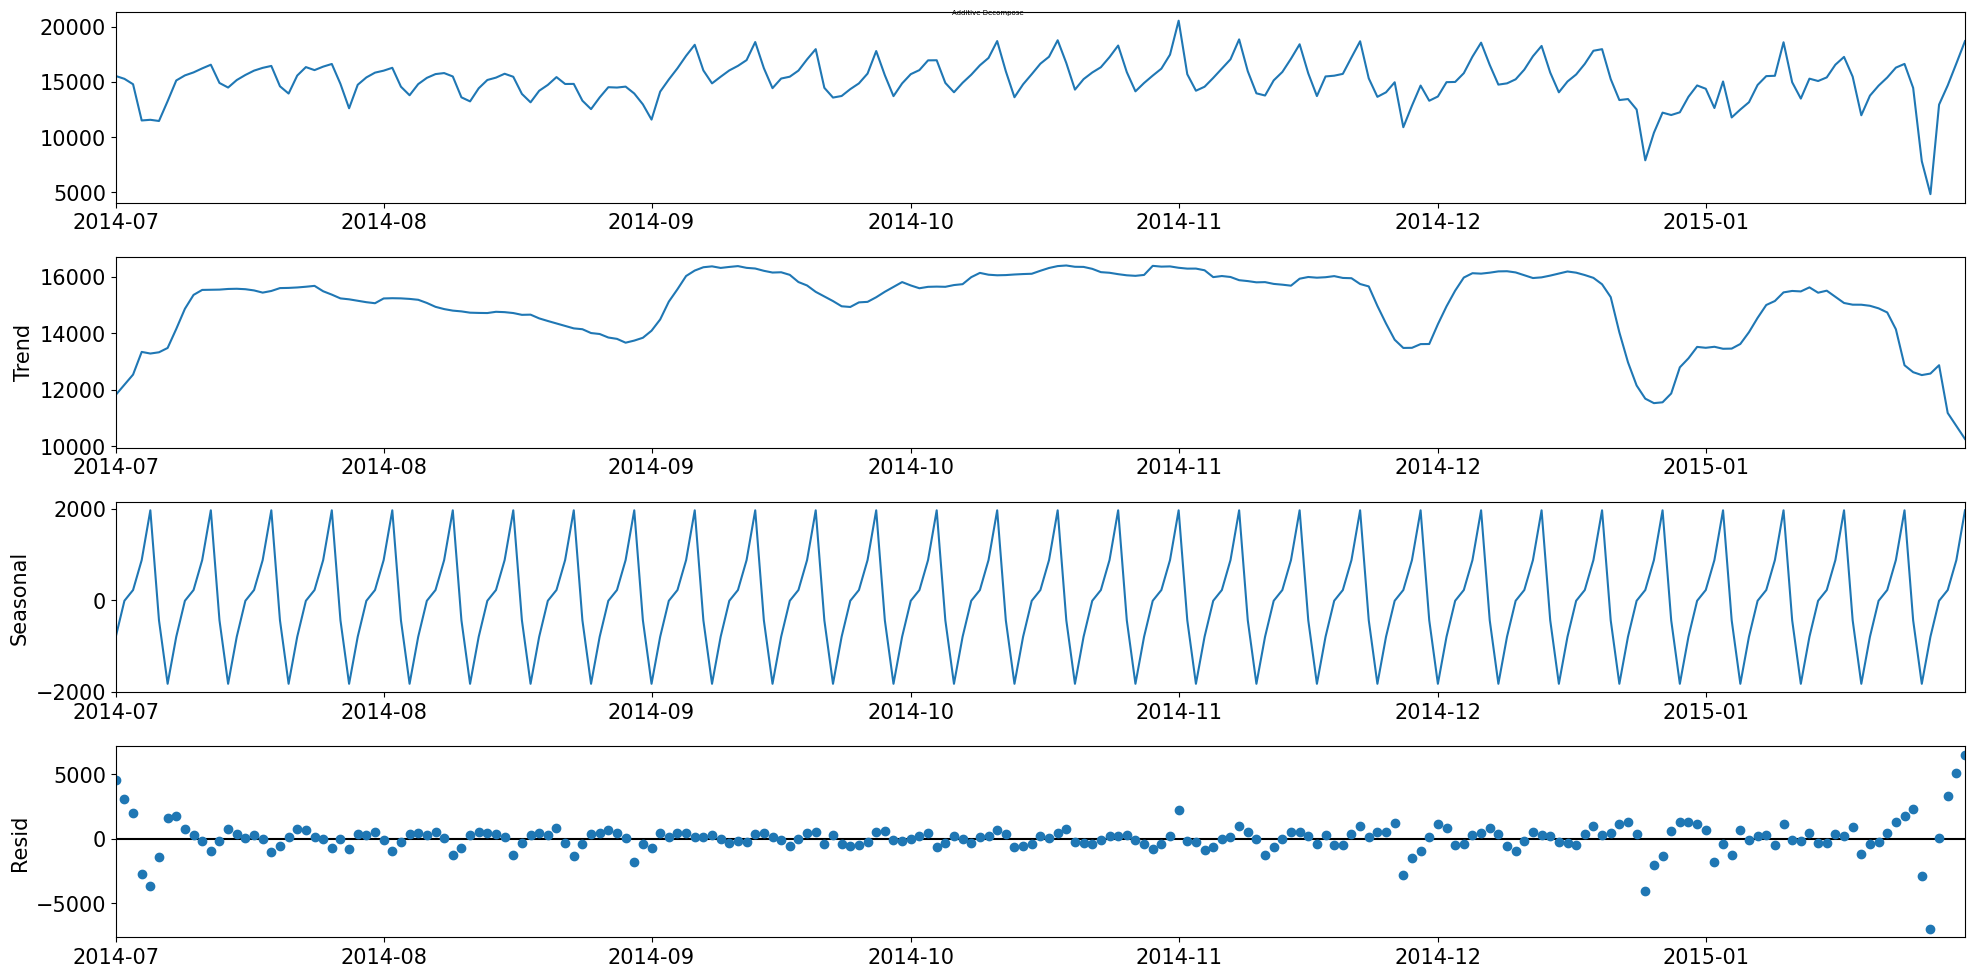

In [72]:
# Plot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (20,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=5)
result_add.plot().suptitle('Additive Decompose', fontsize=5)
plt.show()

In [73]:
result_mul.resid

timestamp
2014-07-01    1.388087
2014-07-02    1.253349
2014-07-03    1.163435
2014-07-04    0.815209
2014-07-05    0.768213
                ...   
2015-01-27    0.405901
2015-01-28    1.004747
2015-01-29    1.295283
2015-01-30    1.469824
2015-01-31    1.607501
Freq: D, Name: resid, Length: 215, dtype: float64

index of outliers
0 1 2 3 4 5 6 7 60 123 149 177 178 185 207 208 209 210 212 213 214 



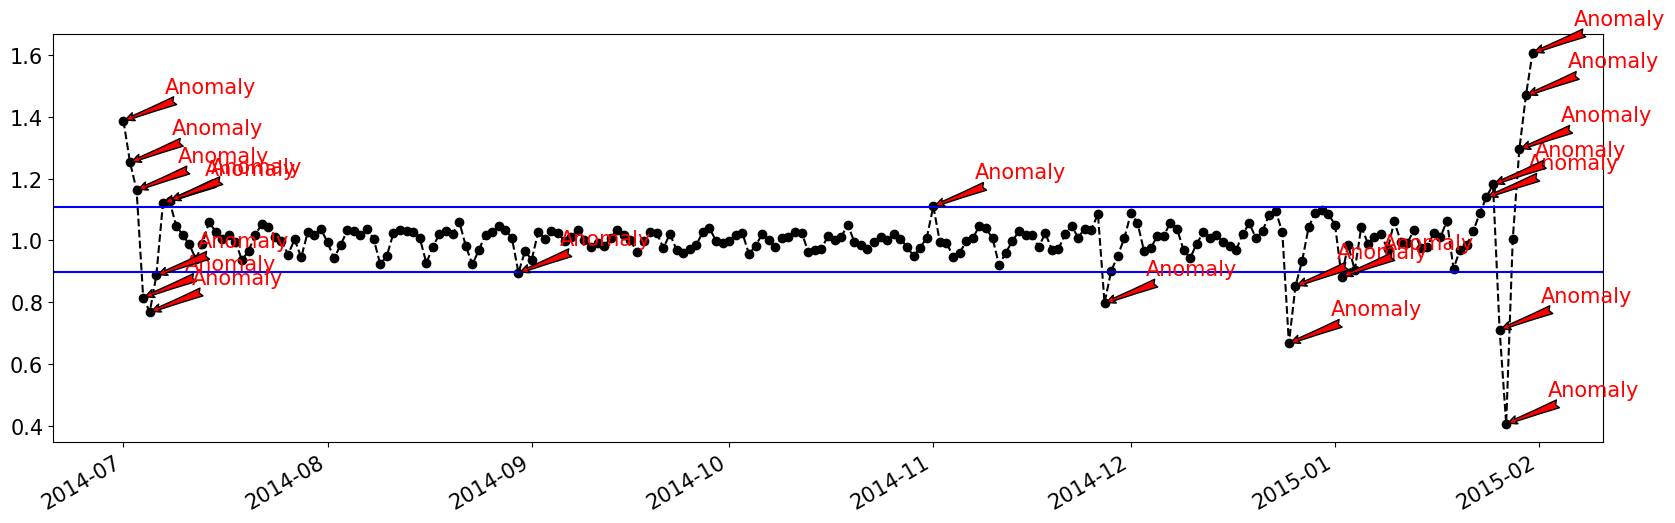

In [75]:
import matplotlib.dates as mdates
import numpy as np

plt.rc('figure',figsize=(20,6))
plt.rc('font',size=15)
fig, ax = plt.subplots()

x = result_mul.resid.index
y = result_mul.resid.values
ax.plot_date(x, y, color='black',linestyle='--')\

Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1
IQR = IQR if IQR > 0 else -1*IQR
lower = Q1 - 1.5*IQR
higher = Q3 + 1.5*IQR

ax.axhline(y=lower, color='blue')
ax.axhline(y=higher, color='blue')
print("index of outliers")
for i in range(len(y)):
    if y[i] < lower or y[i] > higher:
        ax.annotate('Anomaly', (mdates.date2num(x[i]), y[i]), xytext=(30, 20), textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))
        print(i,end=" ")
print()
print()
fig.autofmt_xdate()
plt.show()


# **분류 및 회귀트리**

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [79]:
ts

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667
...,...
2015-01-27,4834.541667
2015-01-28,12947.562500
2015-01-29,14686.145833


In [80]:
outliers_fraction = float(.01)
scaler = StandardScaler()
#전달되어야 하는 데이터는 2차원 배열, but 현재는 1차원 -> reshape으로 해결
np_scaled = scaler.fit_transform(np.array(ts.value).reshape(-1,1))
df_scaled = pd.DataFrame(np_scaled)
df_scaled

,0
0,0.208709
1,0.075844
2,-0.177427
3,-1.875853
4,-1.844541
...,...
210,-5.330402
211,-1.133028
212,-0.233550
213,0.796250


In [81]:
model = IsolationForest(contamination = outliers_fraction)
model.fit(df_scaled)
ts['anomaly'] = model.predict(df_scaled)
ts

,value,anomaly
timestamp,,
2014-07-01,15540.979167,1
2014-07-02,15284.166667,1
2014-07-03,14794.625000,1
2014-07-04,11511.770833,1
2014-07-05,11572.291667,1
...,...,...
2015-01-27,4834.541667,-1
2015-01-28,12947.562500,1
2015-01-29,14686.145833,1


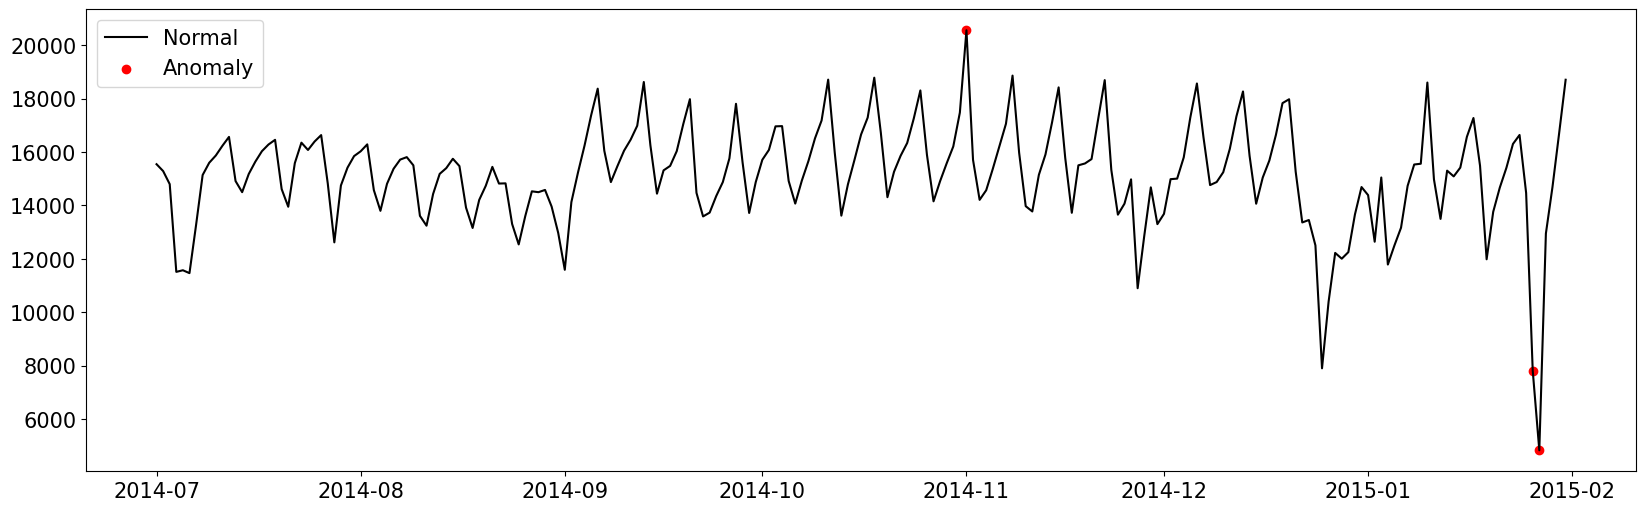

In [82]:
#시각화
fig, ax = plt.subplots(figsize=(20,6))
a = ts.loc[ts['anomaly'] == -1, ['value']] #anomaly
ax.plot(ts.index, ts['value'], color='black', label = 'Normal')
ax.scatter(a.index,a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

# **LSTM - AE**

https://velog.io/@jonghne/LSTM-AE%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%9D%B4%EC%83%81-%ED%83%90%EC%A7%80-2-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC

In [87]:
df_ae = df_ts.iloc[:,:1]
print(df_ae.shape)
df_ae

(10320, 1)


,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309
